**Objective**

It is quite obvious that daily cash withdrawal amounts are time series. Therefore, in this typical cash demand forecast models we will present time series and regression machine learning models to troubleshoot the above use case. We will work on the demand for a single ATM (a group of ATMs can also be worked that is treated as a single ATM) to develop a model for the given data set.

We have to remember that, cash withdrawals from an ATM are not only time dependent. There could be seasonality, e.g. 1) people will have a tendency to withdraw money on Friday for the weekend or 2) end of the month when people get their salaries or 3) between 7–10th day of each month some people get their pension.

So our goal is to predict the amount of transactions for the next few days

In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf

from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [94]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


*Reading Files*

In [95]:

atm = pd.read_csv('/content/atms_data.csv')

In [96]:
atm.shape

(573119, 8)

In [97]:
atm.head()

,Unnamed: 0,Date,ATM_ID,Number_of_Trxs,Amount,capacity,Weekday,Working_day
0,0,20180201,3479212,199,235250,NaN,Thursday,Yes
1,1,20180201,1599756,105,237300,NaN,Thursday,Yes
2,2,20180201,2019227,487,539910,720000.0,Thursday,Yes
3,3,20180201,3200101,354,466900,NaN,Thursday,Yes
4,4,20180201,5129042,224,432610,NaN,Thursday,Yes


In [98]:
atm.ATM_ID.nunique()

2694

In [99]:
# Select numerical columns
numerical = atm.select_dtypes(include='number')

# Loop through each numerical column and use the describe function
for column in numerical.columns:
    print(f"Column: {column}"'\n')
    print(numerical[column].describe())
    print("-" * 50)


Column: Unnamed: 0

count    573119.000000
mean     286559.000000
std      165445.348801
min           0.000000
25%      143279.500000
50%      286559.000000
75%      429838.500000
max      573118.000000
Name: Unnamed: 0, dtype: float64
--------------------------------------------------
Column: Date

count    5.731190e+05
mean     2.018075e+07
std      3.322917e+02
min      2.018020e+07
25%      2.018051e+07
50%      2.018072e+07
75%      2.018103e+07
max      2.018123e+07
Name: Date, dtype: float64
--------------------------------------------------
Column: ATM_ID

count    5.731190e+05
mean     3.060311e+06
std      1.313341e+06
min      1.009104e+06
25%      2.019374e+06
50%      3.050455e+06
75%      4.009450e+06
max      7.089115e+06
Name: ATM_ID, dtype: float64
--------------------------------------------------
Column: Number_of_Trxs

count    573119.000000
mean        135.908462
std         119.018302
min           1.000000
25%          46.000000
50%         106.000000
75%       

*Checking for outliers*

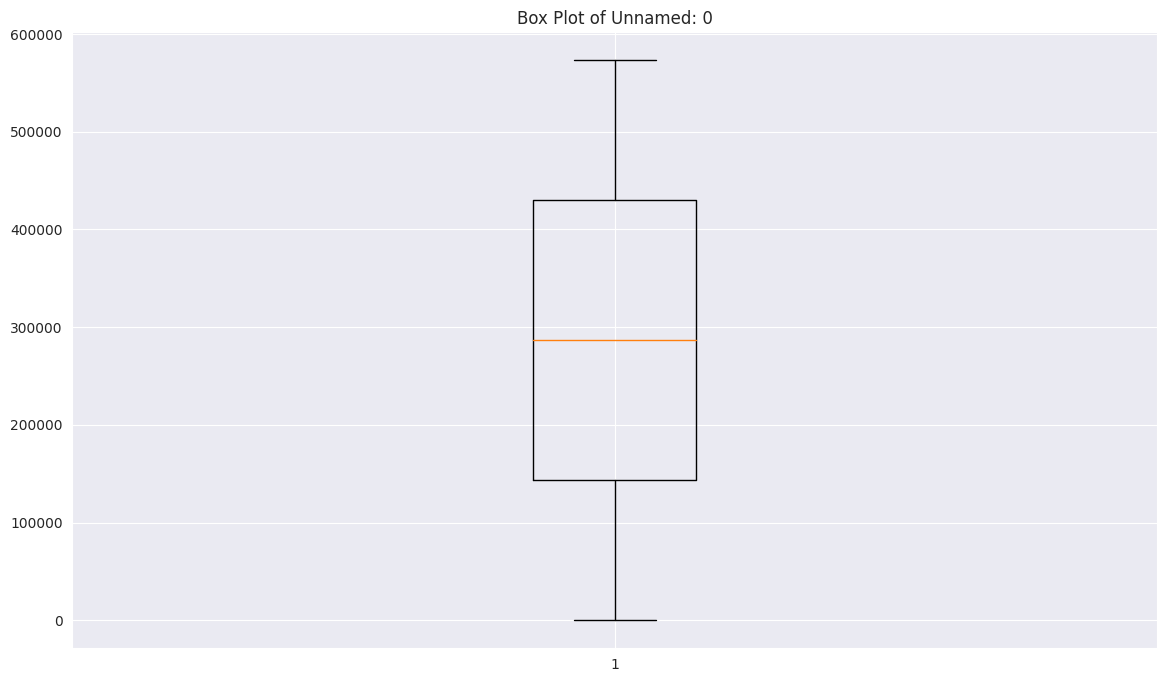

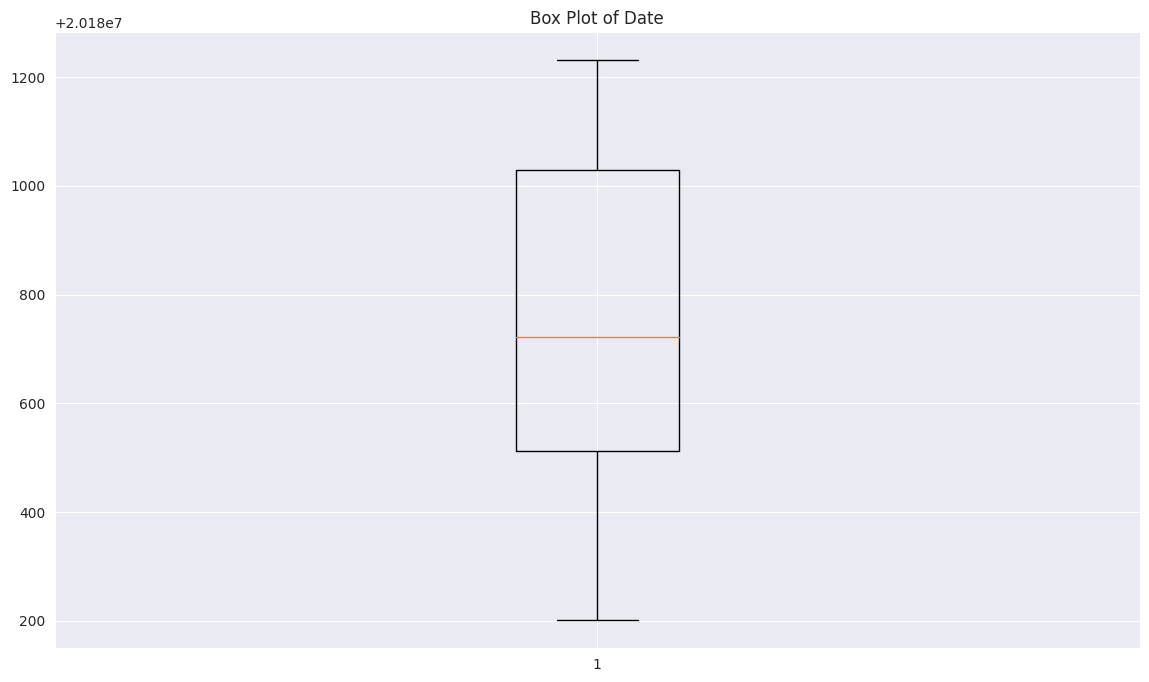

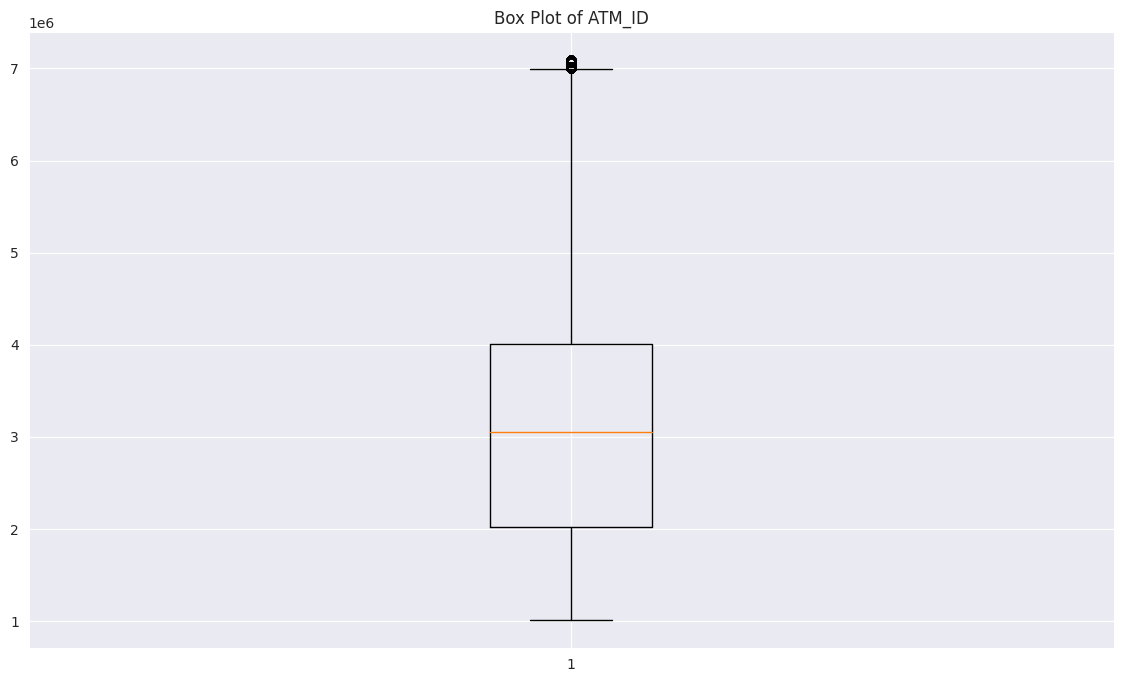

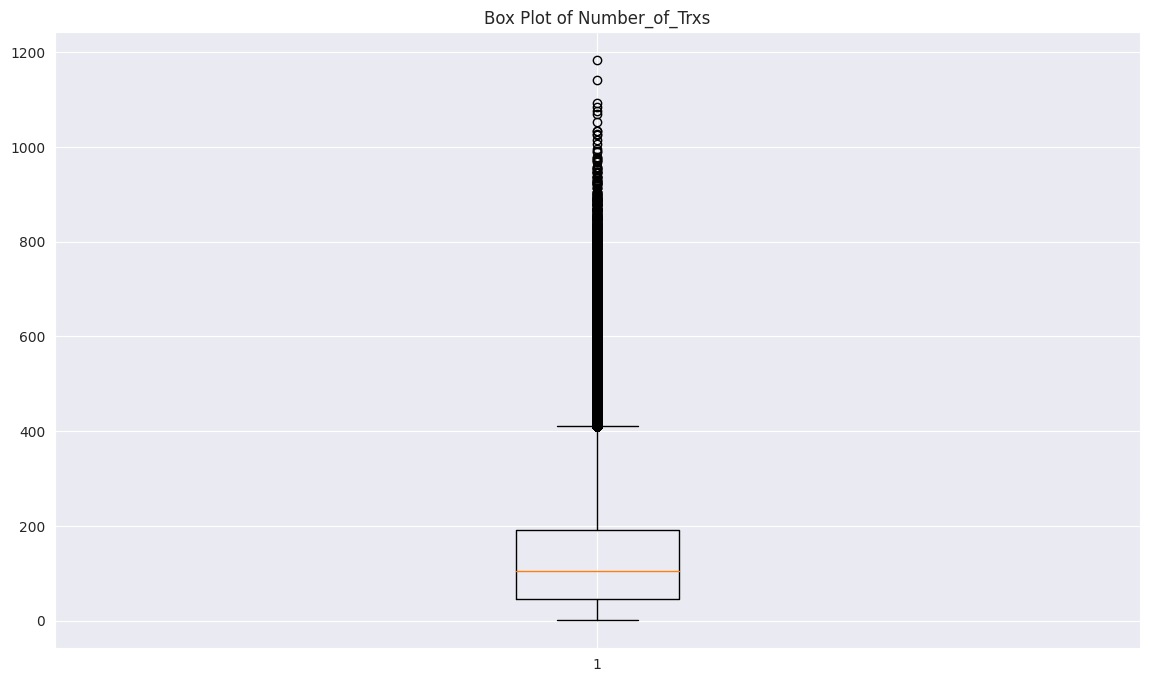

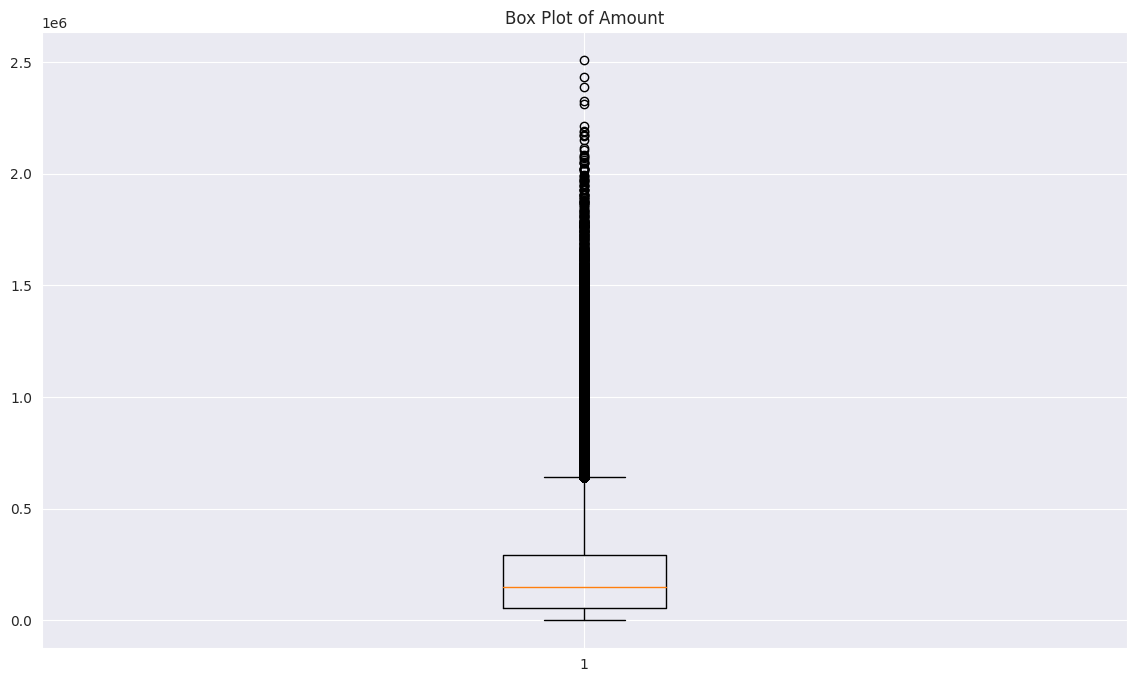

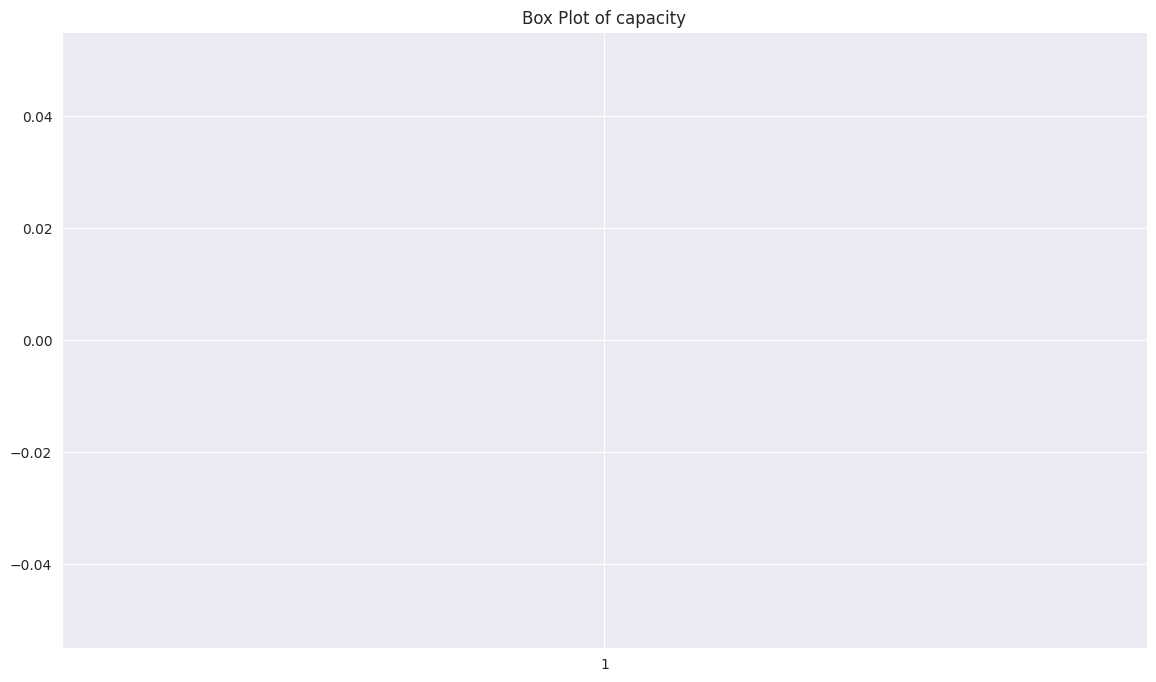

In [100]:
# Select only the numeric columns (continuous data) with more than 2 unique values
continuous_cols = [col for col in numerical if atm[col].nunique() > 2]

# Loop through each continuous column and create a box plot
for column in continuous_cols:
    plt.figure()
    plt.boxplot(atm[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

*onehot encoding*

In [101]:
# Select categorical columns
categorical = atm.select_dtypes(include='object')


In [102]:
one_hot_encoded_data = pd.get_dummies(categorical)
one_hot_encoded_data.head()

,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Working_day_No,Working_day_Yes
0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,1,0,0,0,1
2,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,0,1
4,0,0,0,0,1,0,0,0,1


In [103]:
combined_data = pd.concat([one_hot_encoded_data, numerical], axis=1)

In [104]:
filtered_df = atm[atm['capacity'].notnull()]
occurrences = filtered_df['ATM_ID'].value_counts()
print(occurrences)

1089574    273
2079266    273
3239501    273
2079025    272
1089125    272
          ... 
1879351      5
1779367      3
3149357      2
3149363      2
1879008      1
Name: ATM_ID, Length: 713, dtype: int64


In [105]:
import pandas as pd

# Assuming df is your DataFrame
df = atm[atm['ATM_ID'] == 1089574]  # Replace Column_name and condition as needed
print(df)

        Unnamed: 0      Date   ATM_ID  Number_of_Trxs  Amount  capacity    Weekday Working_day
669            669  20180203  1089574              62   72700  900000.0   Saturday          No
1818          1818  20180208  1089574             126  184560  900000.0   Thursday         Yes
6111          6111  20180225  1089574             361  516390  900000.0     Sunday         Yes
8476          8476  20180206  1089574             114  124610  900000.0    Tuesday         Yes
9547          9547  20180210  1089574             144  219940  900000.0   Saturday          No
9900          9900  20180212  1089574             109   91350  900000.0     Monday         Yes
12435        12435  20180222  1089574             145  168980  900000.0   Thursday         Yes
12818        12818  20180223  1089574              53  106650  900000.0     Friday          No
14134        14134  20180228  1089574             136  203530  900000.0  Wednesday         Yes
14310        14310  20180201  1089574             

# EDA

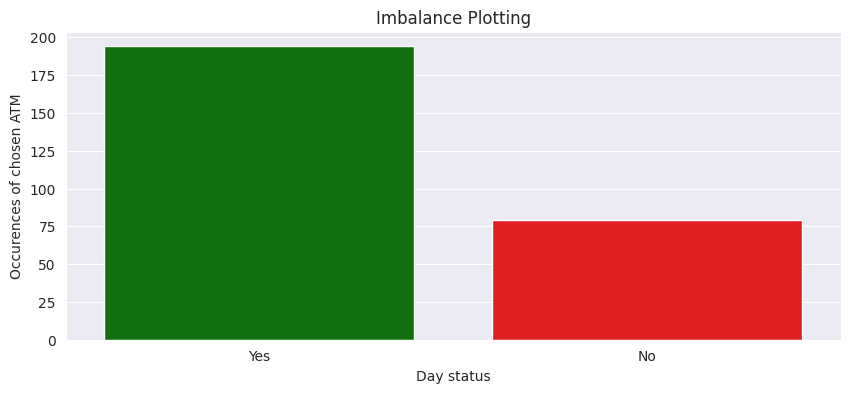

In [106]:
Imbalance = df["Working_day"].value_counts().reset_index() #function is used to count the occurrences of each category in the target variable "TARGET"

plt.figure(figsize=(10,4))
labels= ['Yes','No']
sns.barplot(x=labels,y="Working_day",data = Imbalance,palette= ['g','r'])
plt.xlabel("Day status")
plt.ylabel("Occurences of chosen ATM")
plt.title("Imbalance Plotting")
plt.show()

# Modelling


In [107]:
print(df.columns)

Index(['Unnamed: 0', 'Date', 'ATM_ID', 'Number_of_Trxs', 'Amount', 'capacity', 'Weekday', 'Working_day'], dtype='object')


In [108]:
print(df.head())

      Unnamed: 0      Date   ATM_ID  Number_of_Trxs  Amount  capacity   Weekday Working_day
669          669  20180203  1089574              62   72700  900000.0  Saturday          No
1818        1818  20180208  1089574             126  184560  900000.0  Thursday         Yes
6111        6111  20180225  1089574             361  516390  900000.0    Sunday         Yes
8476        8476  20180206  1089574             114  124610  900000.0   Tuesday         Yes
9547        9547  20180210  1089574             144  219940  900000.0  Saturday          No


In [109]:
# Huber loss function
def huber_loss(y_pred, y, delta=1.0):
    huber_mse = 0.5 * (y - y_pred) ** 2
    huber_mae = delta * (np.abs(y - y_pred) - 0.5 * delta)
    return np.where(np.abs(y - y_pred) <= delta, huber_mse, huber_mae)

In [110]:
# Converting the index to timestamp
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')


In [111]:
print(df)

        Unnamed: 0       Date   ATM_ID  Number_of_Trxs  Amount  capacity    Weekday Working_day
669            669 2018-02-03  1089574              62   72700  900000.0   Saturday          No
1818          1818 2018-02-08  1089574             126  184560  900000.0   Thursday         Yes
6111          6111 2018-02-25  1089574             361  516390  900000.0     Sunday         Yes
8476          8476 2018-02-06  1089574             114  124610  900000.0    Tuesday         Yes
9547          9547 2018-02-10  1089574             144  219940  900000.0   Saturday          No
9900          9900 2018-02-12  1089574             109   91350  900000.0     Monday         Yes
12435        12435 2018-02-22  1089574             145  168980  900000.0   Thursday         Yes
12818        12818 2018-02-23  1089574              53  106650  900000.0     Friday          No
14134        14134 2018-02-28  1089574             136  203530  900000.0  Wednesday         Yes
14310        14310 2018-02-01  1089574  

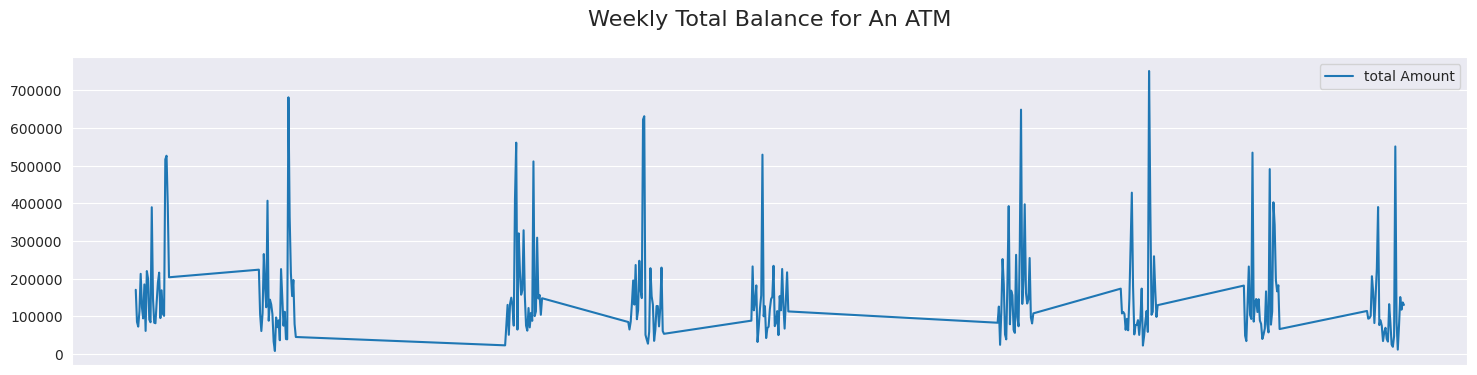

In [112]:
plt.figure(figsize=(18, 4))
plt.plot(data1, label='total Amount')
plt.legend(loc='best')
plt.title('Weekly Total Balance for An ATM\n',
          fontdict={'fontsize': 16,
                    'fontweight': 5})
plt.show()



### **Additive seasonal decomposition**





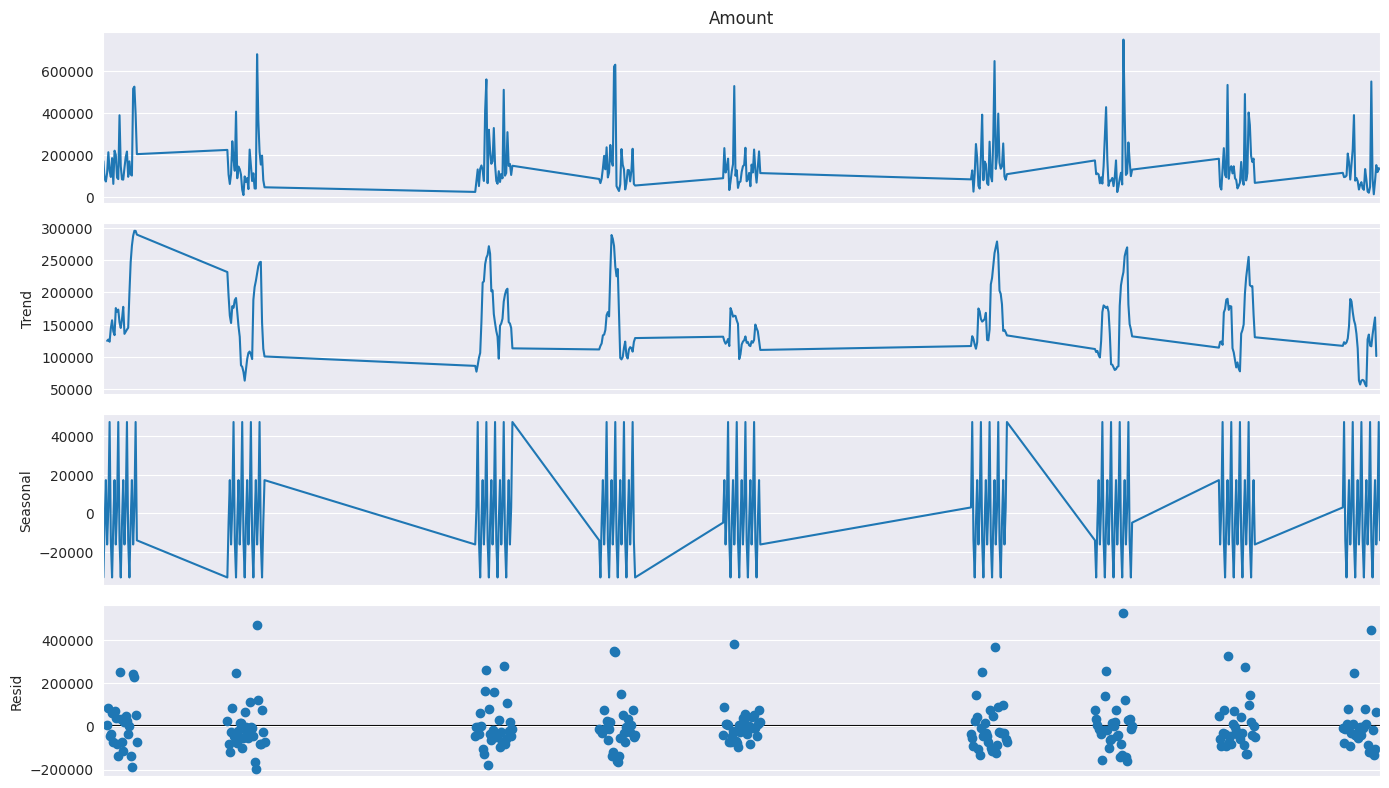

In [113]:
from pylab import rcParams
import statsmodels.api as sm

# Set figure size
rcParams['figure.figsize'] = (14, 8)

# Assuming data1 has a datetime index and an "Amount" column
decomposition = sm.tsa.seasonal_decompose(data1.Amount, model='additive',period=7)

# Plot the decomposition components
fig = decomposition.plot()
plt.show()



### **Multiplicative seasonal decomposition**


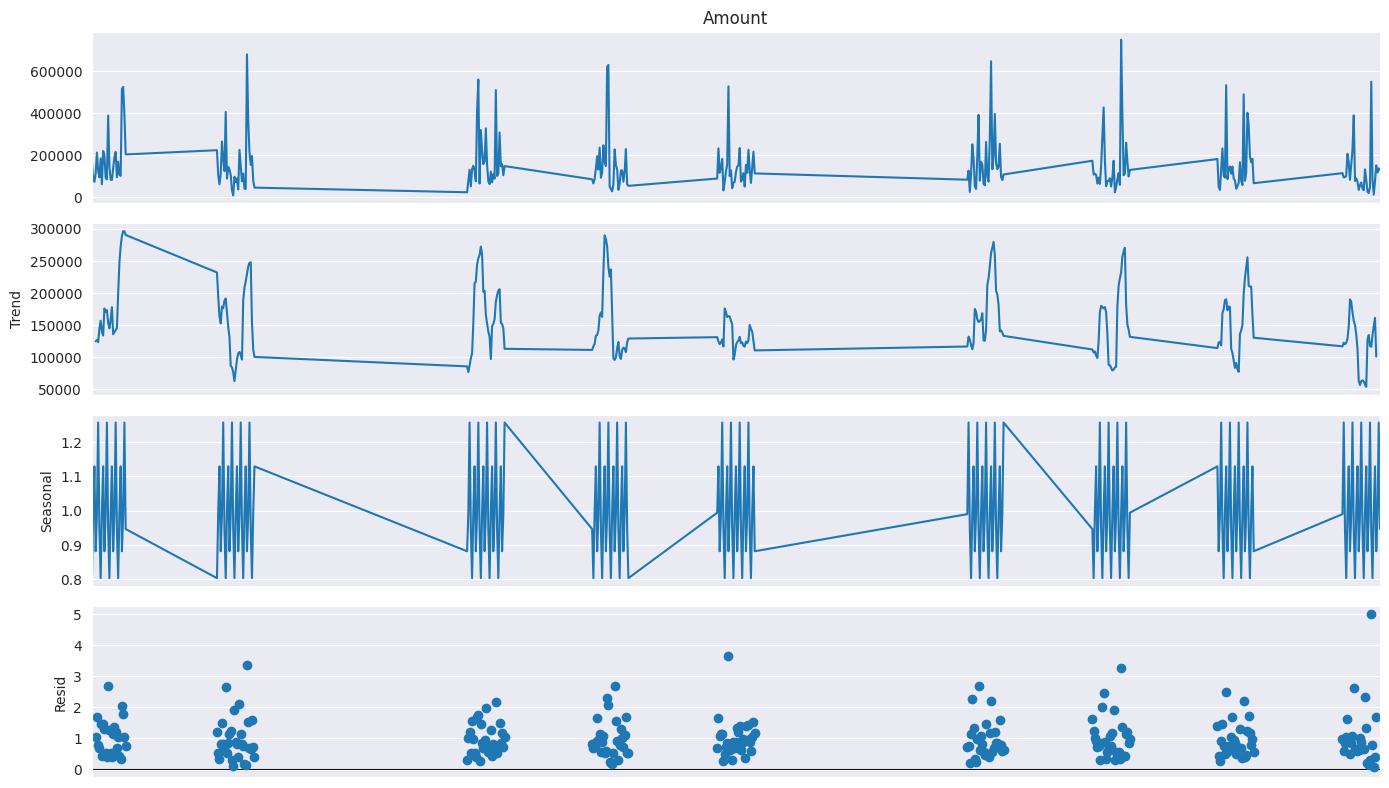

In [115]:
decomposition = sm.tsa.seasonal_decompose(data1.Amount, model='multiplicative',period=7)
fig = decomposition.plot()
plt.show()

* **Inference** : The data contains level, trend and seasonality.

# Data Preprocessing

**Check Stationary**

Augmented Dickey-Fuller (ADF) test

In [116]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data1['Amount'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])


ADF Statistic: -4.242219
Critical Values @ 0.05: -2.87
p-value: 0.000558


**Inference** : p-value is smaller than 0.05. This means that the series is stationary.

# Check ACF & PACF




In [118]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [119]:
# Visualizations
lag_acf = 20
lag_pacf = 20

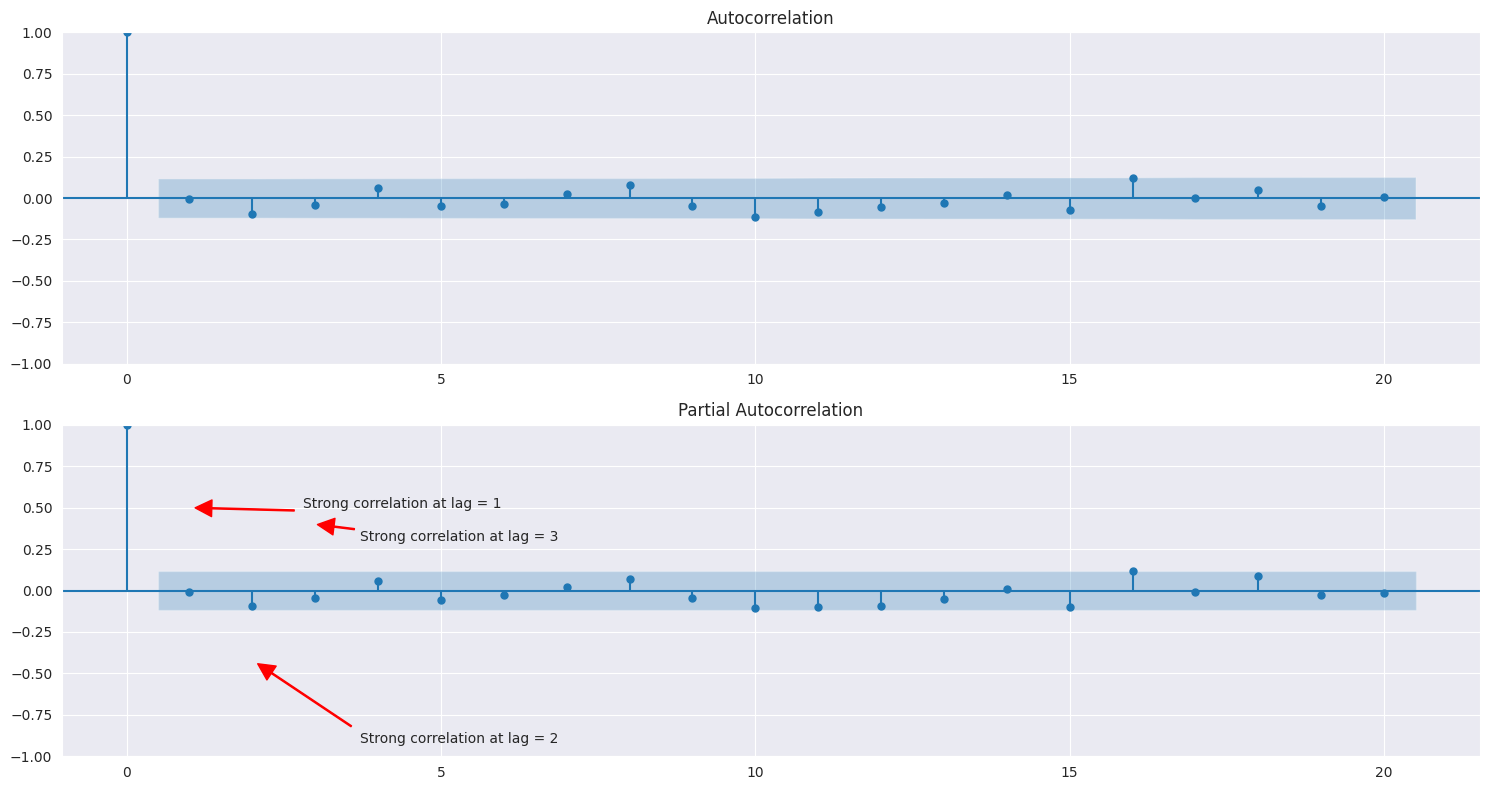

In [121]:
# Draw ACF and PACF plots
data_column = df['Amount']
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

plot_acf(data_column, lags=lag_acf, ax=ax[0])
plot_pacf(data_column, lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1',
               xy=(1, 0.5),
               xycoords='data',
               xytext=(0.17, 0.75),
               textcoords='axes fraction',
               arrowprops=dict(color='red',
               shrink=0.05, width=0.8))

ax[1].annotate('Strong correlation at lag = 2',
               xy=(2, -0.42),
               xycoords='data',
               xytext=(0.21, 0.04),
               textcoords='axes fraction',
               arrowprops=dict(color='red',
               shrink=0.05, width=0.8))

ax[1].annotate('Strong correlation at lag = 3',
               xy=(3, 0.4),
               xycoords='data',
               xytext=(0.21, 0.65),
               textcoords='axes fraction',
               arrowprops=dict(color='red',
               shrink=0.05, width=0.8))


plt.tight_layout()
plt.show()
